<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

These scripts display and forecast the path of the Covid-19 pandemic. We make use of the following publically available datasets: 

For country-level case and population data
* https://covid.ourworldindata.org/data/ecdc/full_data.csv
* https://covid.ourworldindata.org/data/ecdc/locations.csv

For U.S. state-level case and population data
* https://github.com/nytimes/covid-19-data
* https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

We forecast each day's new confirmed cases according to the formula

$ c_t = (c_{t-1} + contagious_{t-1}) \times R_{0,t}/days_{contagious} \times (1 - immune_{t-1}) $

where
* $ c_t = \text{new confirmed casess at time t} $
* $ C_t = \text{cumulative confirmed cases at time t} $
* $ contagious_t = C_t - C_{t - days_{contagious}}$
* $ days_{contagious} = \text{number of days each cases is assumed to be contagious} = 14 \text{, by default, assumed}$
* $ immune = \text{fraction of the population that is immune} = prevalence/(1 - unreported)$
* $ prevalance = \text{cumulative confirmed cases as fraction of the population} = C_t/population$
* $ unreported = \text{fraction of all cases that are not reported} $
* $ R_{0,t} = \text{basic reproduction number} \geq 0$

Given historical data to time $t-1$, all of the above terms are endogenous to the model except $R_{0,t}$, the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number).


## Loading Functions and Data. Run these first.

Run imports and functions.

In [0]:
import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    Loads covid_data into new dataframe, merges population and continent fields 
    from pop_data, and passes to munge_data() and order_columns() for
    further processing. This is the first function called after importing
    CSV files.

    Parameters
    ----------
    covid_data (pd.DataFrame) : raw data from Covid-19 CSV file [1] or similar
    pop_data (pd.DataFrame) : raw data from population CSV file [2] or similar
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    
    Notes
    ----
    [1] https://covid.ourworldindata.org/data/ecdc/locations.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe to be processed
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['prevalence'] = df['total_cases']/df['population']       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['repro_number'] = df['new_cases']/df['contagious'] * contagious_days
    
    np.seterr(divide = 'ignore') 
    '''
    Otherwise, get "RuntimeWarning: divide by zero encountered in log result".
    Warning happens when np.log(0), for example when total_cases declines 100%.
    As total_cases is cumulative and gross of recovered, this example could 
    only happen with a reporting agency error. 
    
    Better to ignore this RuntimeWarning, and leave the public data unaltered.
    '''
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['days_to_dbl'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'days_to_dbl']] = np.NaN
    np.seterr(divide = 'warn') 
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'prevalence', 
                    'growth', 'days_to_dbl', 'contagious', 'repro_number',  
                    'new_deaths', 'total_deaths', 'fatality', 
                    'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def create_repro_path(days, last, move=[]):
    '''
    Creates a path of future reproduction numbers to be used in forecast().

    Parameters
    ----------
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    move[0] (float) : target reproduction number 
    move[1] (float) : daily rate of change from last to target       
    move[2] (float) : default 0; x_0, the x value of the sigmoid's midpoint [1]
    move[3] (float) : default 1; k, the logistic growth rate 
                    or steepness of the curve [1]

    Returns
    -------
    pd.Series: series of forecast reproduction numbers
    
    Notes
    -----
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    days_motion = round(1/rate) if rate else days
    L = target - last

    y = []
    for x in np.linspace(-6, 6, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, repro_move=[], unreported=0.0,
             contagious_days=14, replace=True):
    '''
    Forecasts reproduction numbers.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe of inputs to forecast
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    repro_move (list of floats) : parameters for reproduction number motion
        see create_repro_path() docstring for details on list items
    asymptomatic (float) : portion of total contagious that goes unreported, 
        between 0 and 1
    contagious_days (int) : number of days infected person assumed contagious
    replace (bool) : if True, replace existing forecast records

    Returns
    -------
    pd.DataFrame: dataframe with appended forecast records
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        last_repro = df.iloc[-1]['repro_number']
        new_repros = create_repro_path(days, last_repro, repro_move)

        for i in range(days):

            last = df.iloc[-1]
            repro_number_ = new_repros[i]  
            
            trans_rate = last['repro_number']/contagious_days

            # adjust for herd immunity
            immune = last['prevalence']/(1 - unreported)

            new_cases_ = ((last['contagious'] + last['new_cases']) 
                          * trans_rate * (1 - immune))
            total_cases_ = last['total_cases'] + new_cases_
            prevalence_ = total_cases_/last['population']
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days + 1]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            days_to_dbl_ = np.log(2)/growth_
            total_deaths_ = total_cases_ * last['fatality']
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'prevalence': prevalence_,
                    'repro_number': repro_number_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'days_to_dbl': days_to_dbl_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': last['fatality'],
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis, maximum 2
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 20
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['total_deaths', 'new_cases'],
             right='repro_number',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number',
             left_yscale=1000):
    '''
    Lineplots time series of Total Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                start=10, ascending=True, rolling=1, logy=True,
                min_cases=10):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    locations (list of str) : names of locations to be plotted
    column (str) : name of column to be plotted for each location
    title (str) : plot title
    start (int) : starting value for the plotted column
    ascending (bool) : if True, plot values above start; if False, below
    rolling (int) : days over which to apply a rolling mean
    logy (bool) : if True, configure y-axis as a log(10) scale
    min_cases (int) : minimum threshold total_cases; 
                      ignored if column='total_cases'
    
    Note
    ----
    The parameter min_cases is especially useful when plotting repro_number, as
    early repro_number values are highly variable.
    '''
    
    data = df.copy()
    
    # apply rolling mean to each location
    data = data.groupby(level=0).rolling(rolling).mean()
    
    # unless plotting total_cases itself, apply a total_cases threshold
    if column != 'total_cases':
        data = data[data['total_cases'] >= min_cases]
    
    if ascending:
        data = data[data[column] >= start]
    else:
        data = data[data[column] <= start]        

    # create column representing days since cutoff values
    data['days_since'] = data.groupby(level=0).cumcount()
    data.loc[data['days_since'] == 0, column] = start
    
    # move location to column, then pivot
    data.reset_index(level=1, inplace=True) 
    pivoted = data.pivot(index='days_since', columns='location', values=column)
    pivoted.index.name = "days since " + str(start) + " " + column

    pivoted[locations].plot(logy=logy, title=title or column)

Load country and U.S. state-level data from public sources.

In [0]:
'''
Load country-level data from https://covid.ourworldindata.org
'''

covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=14)

'''
Load US state-level data from 
https://github.com/nytimes/covid-19-data
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
'''

covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/'
                                'covid-19-data/master/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index(['location','date'], inplace=True)
covid_state_data.sort_index(inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index.levels[0]:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)


pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=14)


## United States

This is the last one week.

In [50]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-13,Mon,27620,557571,0.001684,0.050805,13.643206,414546.0,0.932779,1500,22108,0.039651,actual,331002647.0,North America
2020-04-14,Tue,25023,582594,0.001760,0.043901,15.788979,417974.0,0.838143,1541,23649,0.040593,actual,331002647.0,North America
2020-04-15,Wed,26922,609516,0.001841,0.045175,15.343719,419898.0,0.897618,2408,26057,0.042750,actual,331002647.0,North America
2020-04-16,Thu,30148,639664,0.001933,0.048278,14.357461,422943.0,0.997941,4928,30985,0.048439,actual,331002647.0,North America
2020-04-17,Fri,31667,671331,0.002028,0.048319,14.345150,425791.0,1.041210,2299,33284,0.049579,actual,331002647.0,North America
2020-04-18,Sat,30833,702164,0.002121,0.044905,15.435965,424199.0,1.017593,3770,37054,0.052771,actual,331002647.0,North America
2020-04-19,Sun,32922,735086,0.002221,0.045821,15.127446,422849.0,1.090006,1856,38910,0.052933,actual,331002647.0,North America


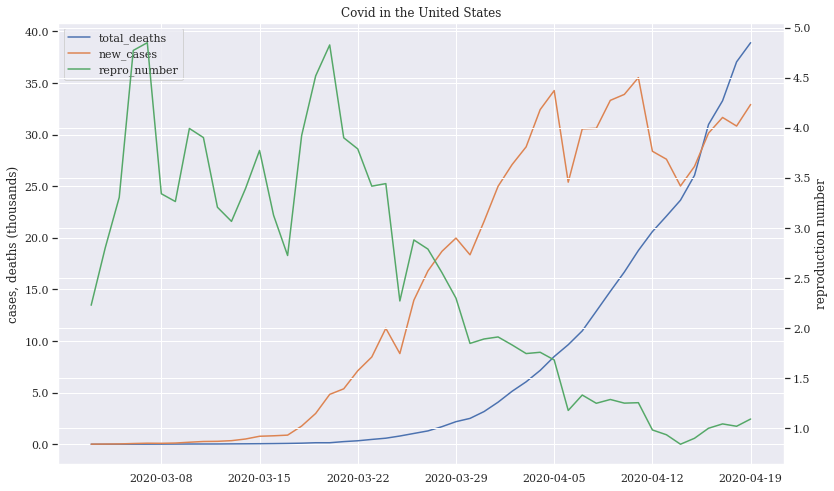

In [51]:
plot_cdr(US_Cov[US_Cov['source']=='actual'], 
         'Covid in the United States','W')

Now let's forecast the next 100 days. Start with estimating the daily percent change in the reproduction number. Assume a target of 0.7.

In [52]:
days_back = 14
target = 0.7
repros = US_Cov[US_Cov['source']=='actual'].repro_number - target
repros.pct_change().tail(days_back).mean()

-0.009614616916579697

Plug this estimate into forecast model, print the results, and plot.

In [53]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.03, -4])
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-07-22,Wed,310.526195,1.473902e+06,0.004453,0.000211,3289.653710,5612.660297,0.700018,16.436953,78017.458224,0.052933,forecast,331002647.0,North America
2020-07-23,Thu,294.848032,1.474197e+06,0.004454,0.000200,3465.288377,5329.287139,0.700018,15.607068,78033.065292,0.052933,forecast,331002647.0,North America
2020-07-24,Fri,279.961420,1.474477e+06,0.004455,0.000190,3650.262494,5060.220393,0.700018,14.819081,78047.884373,0.052933,forecast,331002647.0,North America
2020-07-25,Sat,265.826401,1.474743e+06,0.004455,0.000180,3845.072656,4804.737850,0.700018,14.070878,78061.955251,0.052933,forecast,331002647.0,North America
2020-07-26,Sun,252.405032,1.474995e+06,0.004456,0.000171,4050.241888,4562.153724,0.700018,13.360450,78075.315701,0.052933,forecast,331002647.0,North America
2020-07-27,Mon,239.661281,1.475235e+06,0.004457,0.000162,4266.321055,4331.816832,0.700018,12.685890,78088.001591,0.052933,forecast,331002647.0,North America
2020-07-28,Tue,227.560938,1.475463e+06,0.004458,0.000154,4493.890330,4113.108866,0.700018,12.045388,78100.046979,0.052933,forecast,331002647.0,North America


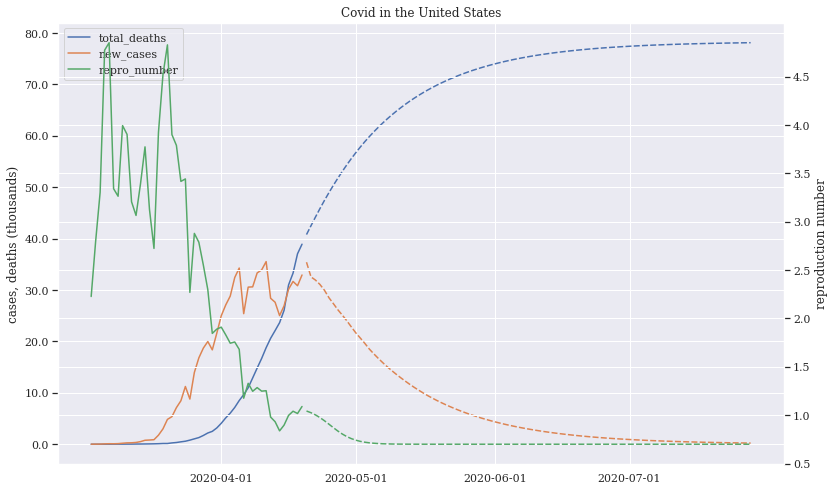

In [54]:
plot_cdr(default_scenario, 'Covid in the United States')

### Scenario: Relax on May 1 

In [55]:
forecast_days = 100
relax_date = date(2020, 5, 1) 
relax_days = 7

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relation period
US_Cov = forecast(US_Cov, stage_1, repro_move=[0.7, 0.03, -4], replace=True)

stage_2 = relax_days # days during relation period
US_Cov = forecast(US_Cov, stage_2, repro_move=[1.0, None, 0], replace=False)

stage_3 = forecast_days - stage_1 - stage_2 # days during retrenchment
US_Cov = forecast(US_Cov, stage_3, repro_move=[0.7, 0.10,  0], replace=False)

relax_scenario = US_Cov.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-07-22,Wed,493.064709,1.660655e+06,0.005017,0.000297,2334.191635,8908.156222,0.70074,26.099188,87902.763074,0.052933,forecast,331002647.0,North America
2020-07-23,Thu,468.197296,1.661123e+06,0.005018,0.000282,2458.879359,8458.910626,0.70074,24.782892,87927.545966,0.052933,forecast,331002647.0,North America
2020-07-24,Fri,444.585005,1.661568e+06,0.005020,0.000268,2590.184110,8032.339400,0.70074,23.533032,87951.078998,0.052933,forecast,331002647.0,North America
2020-07-25,Sat,422.164538,1.661990e+06,0.005021,0.000254,2728.456100,7627.293015,0.70074,22.346259,87973.425257,0.052933,forecast,331002647.0,North America
2020-07-26,Sun,400.875484,1.662391e+06,0.005022,0.000241,2874.066137,7242.678119,0.70074,21.219374,87994.644631,0.052933,forecast,331002647.0,North America
2020-07-27,Mon,380.660373,1.662772e+06,0.005023,0.000229,3027.406038,6877.457395,0.70074,20.149336,88014.793968,0.052933,forecast,331002647.0,North America
2020-07-28,Tue,361.464676,1.663133e+06,0.005025,0.000217,3188.888959,6530.648081,0.70074,19.133259,88033.927226,0.052933,forecast,331002647.0,North America


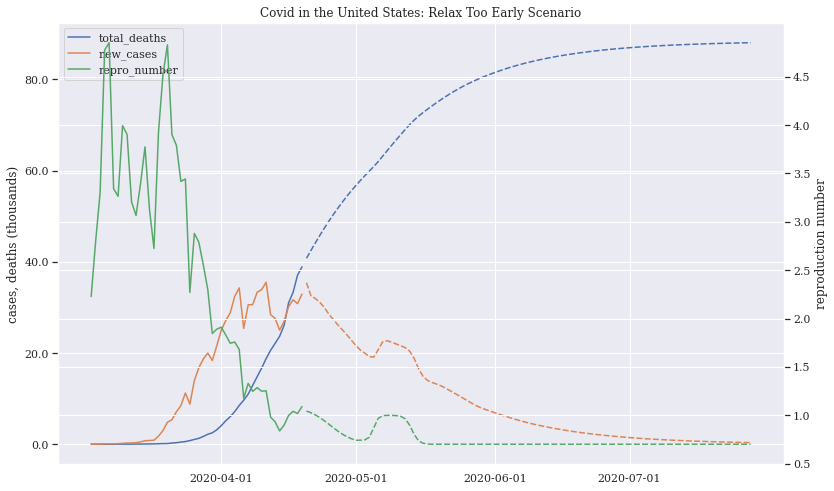

In [56]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario')

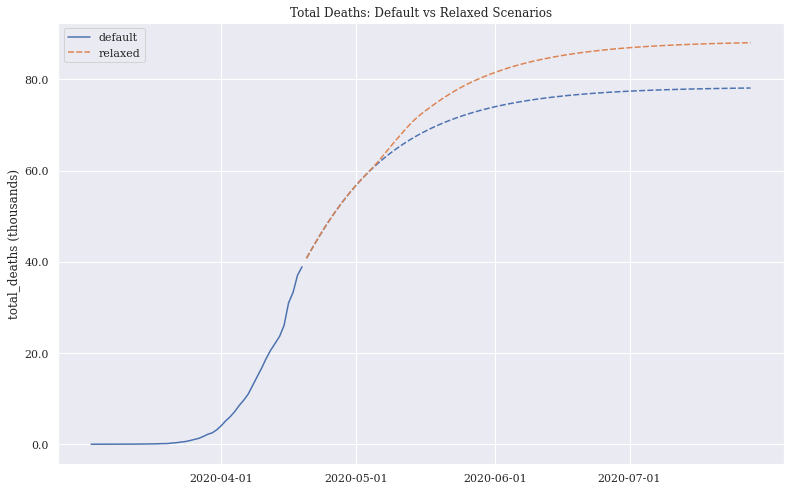

In [57]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Total Deaths: Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

### Scenario: No Further Improvements on Today's Reproduction Number

In [58]:
US_Cov = forecast(US_Cov, 365*2)
no_improvements_scenario = US_Cov.copy()
no_improvements_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2022-04-13,Wed,647.128972,5.467164e+07,0.165170,0.000012,58559.066306,9169.394499,1.090006,34.254207,2.893911e+06,0.052933,forecast,331002647.0,North America
2022-04-14,Thu,638.053016,5.467228e+07,0.165172,0.000012,59392.735190,9040.813371,1.090006,33.773794,2.893945e+06,0.052933,forecast,331002647.0,North America
2022-04-15,Fri,629.104148,5.467291e+07,0.165174,0.000012,60238.281893,8914.032192,1.090006,33.300107,2.893978e+06,0.052933,forecast,331002647.0,North America
2022-04-16,Sat,620.280593,5.467353e+07,0.165175,0.000011,61095.875646,8789.025850,1.090006,32.833053,2.894011e+06,0.052933,forecast,331002647.0,North America
2022-04-17,Sun,611.580603,5.467414e+07,0.165177,0.000011,61965.688092,8665.769586,1.090006,32.372540,2.894043e+06,0.052933,forecast,331002647.0,North America
2022-04-18,Mon,603.002453,5.467474e+07,0.165179,0.000011,62847.893319,8544.238980,1.090006,31.918477,2.894075e+06,0.052933,forecast,331002647.0,North America
2022-04-19,Tue,594.544442,5.467534e+07,0.165181,0.000011,63742.667895,8424.409952,1.090006,31.470772,2.894107e+06,0.052933,forecast,331002647.0,North America


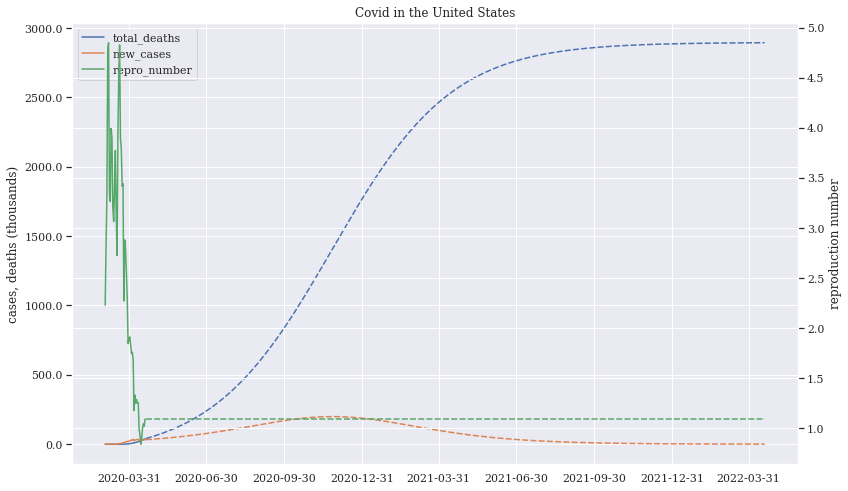

In [59]:
plot_cdr(US_Cov, 'Covid in the United States', date_freq='Q')

### Scenario: What if 90% of infections go unreported?

In [60]:
US_Cov = forecast(US_Cov, 100, repro_move=[0.7, 0.025, -4], unreported=0.9)
unreported_scenario = US_Cov.copy()
unreported_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-07-22,Wed,207.315759,1.446726e+06,0.004371,0.000143,4836.689326,3887.185911,0.700018,10.973758,76578.921676,0.052933,forecast,331002647.0,North America
2020-07-23,Thu,195.782040,1.446921e+06,0.004371,0.000135,5122.337190,3670.949463,0.700018,10.363249,76589.284925,0.052933,forecast,331002647.0,North America
2020-07-24,Fri,184.889874,1.447106e+06,0.004372,0.000128,5424.816039,3466.738721,0.700018,9.786698,76599.071624,0.052933,forecast,331002647.0,North America
2020-07-25,Sat,174.603592,1.447281e+06,0.004372,0.000121,5745.117481,3273.885213,0.700018,9.242219,76608.313843,0.052933,forecast,331002647.0,North America
2020-07-26,Sun,164.889499,1.447446e+06,0.004373,0.000114,6084.291674,3091.757544,0.700018,8.728027,76617.041869,0.052933,forecast,331002647.0,North America
2020-07-27,Mon,155.715774,1.447601e+06,0.004373,0.000108,6443.450757,2919.759377,0.700018,8.242438,76625.284307,0.052933,forecast,331002647.0,North America
2020-07-28,Tue,147.052361,1.447749e+06,0.004374,0.000102,6823.772461,2757.327519,0.700018,7.783861,76633.068169,0.052933,forecast,331002647.0,North America


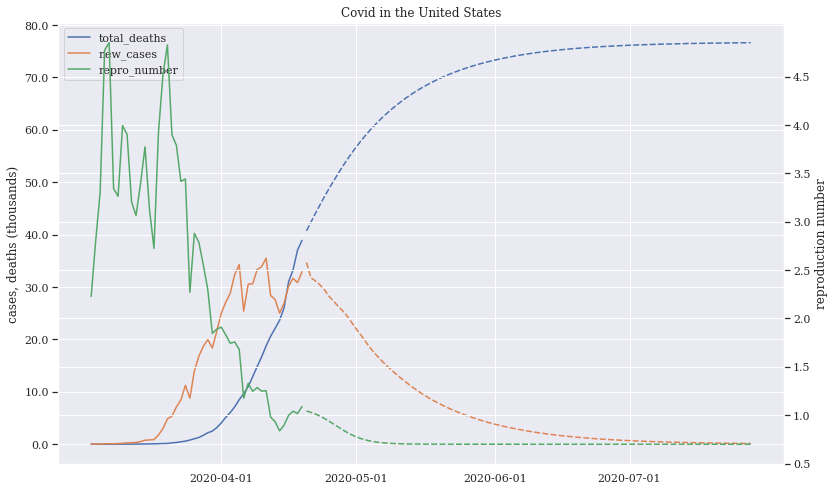

In [61]:
plot_cdr(unreported_scenario, 'Covid in the United States')

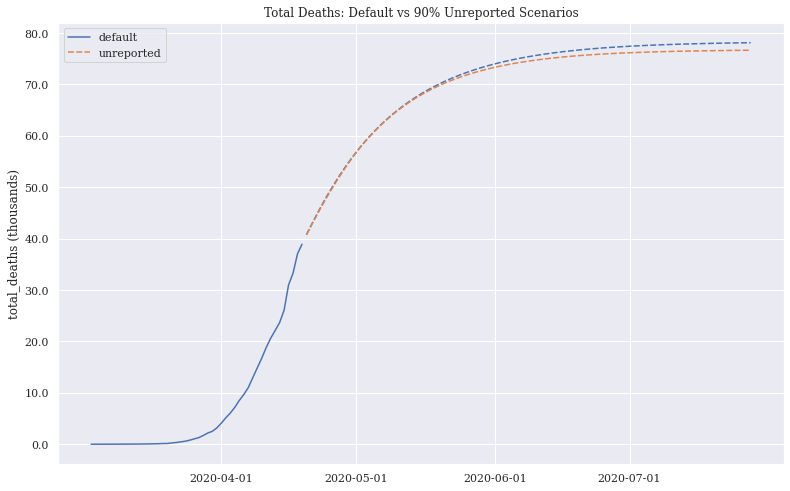

In [62]:
column = 'total_deaths'

unreported = unreported_scenario[unreported_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, unreported], axis=1)
compare.columns = ['default','source','unreported']

plot_timeline(compare, 'Total Deaths: Default vs 90% Unreported Scenarios',
              date_freq='MS',
              left=['default','unreported'], right=None,
              left_ylabel=column + ' (thousands)')

## Other Countries

### China

In [63]:
China_Cov = df[df['total_cases']>100].loc['China']
China_Cov[China_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-13,Mon,112,83209,0.000058,0.001347,514.618382,1052.0,1.490494,2,3345,0.040200,actual,1.439324e+09,Asia
2020-04-14,Tue,94,83303,0.000058,0.001129,613.921867,1062.0,1.239171,0,3345,0.040155,actual,1.439324e+09,Asia
2020-04-15,Wed,49,83352,0.000058,0.000588,1178.739184,1057.0,0.649007,1,3346,0.040143,actual,1.439324e+09,Asia
2020-04-16,Thu,50,83402,0.000058,0.000600,1155.850615,1007.0,0.695134,0,3346,0.040119,actual,1.439324e+09,Asia
2020-04-17,Fri,352,83754,0.000058,0.004212,164.578890,1289.0,3.823119,1290,4636,0.055353,actual,1.439324e+09,Asia
2020-04-18,Sat,31,83785,0.000058,0.000370,1873.051357,1258.0,0.344992,0,4636,0.055332,actual,1.439324e+09,Asia
2020-04-19,Sun,18,83803,0.000058,0.000215,3226.754146,1228.0,0.205212,0,4636,0.055320,actual,1.439324e+09,Asia


In [64]:
days_back = 21
target = 0.7
repros= China_Cov[China_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-17.529619016750146

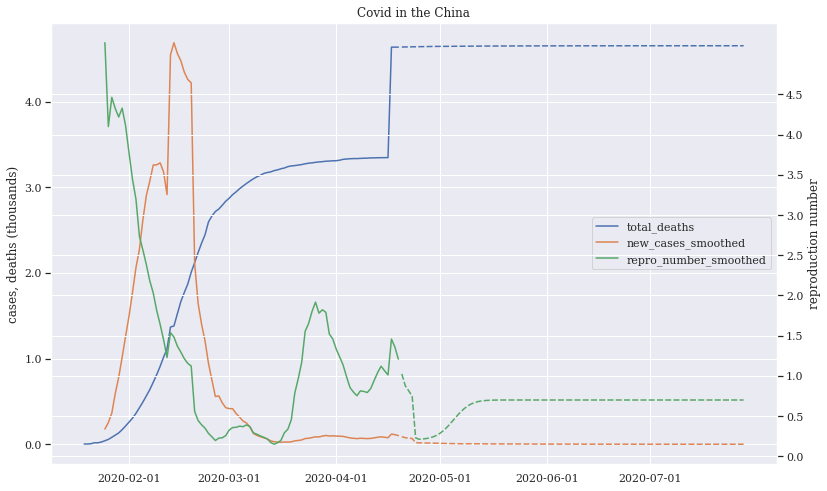

In [65]:
China_Cov = forecast(China_Cov, 100, repro_move=[0.7, 0.04])

China_Cov['new_cases_smoothed']=China_Cov['new_cases'].rolling(7).mean()
China_Cov['repro_number_smoothed']=China_Cov['repro_number'].rolling(7).mean()
plot_cdr(China_Cov, 'Covid in the China',
         left = ['total_deaths', 'new_cases_smoothed'],
         right='repro_number_smoothed')

### Italy

In [66]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-13,Mon,4092,156363,0.002586,0.026518,26.138349,58674.0,0.976378,431,19901,0.127274,actual,60461828.0,Europe
2020-04-14,Tue,3153,159516,0.002638,0.019964,34.719849,57777.0,0.764006,564,20465,0.128294,actual,60461828.0,Europe
2020-04-15,Wed,2972,162488,0.002687,0.018460,37.548760,56696.0,0.733879,604,21069,0.129665,actual,60461828.0,Europe
2020-04-16,Thu,2667,165155,0.002732,0.016280,42.575892,54581.0,0.684084,578,21647,0.131071,actual,60461828.0,Europe
2020-04-17,Fri,3786,168941,0.002794,0.022665,30.582117,53699.0,0.987057,525,22172,0.131241,actual,60461828.0,Europe
2020-04-18,Sat,3493,172434,0.002852,0.020465,33.869863,52607.0,0.929572,575,22747,0.131917,actual,60461828.0,Europe
2020-04-19,Sun,3491,175925,0.002910,0.020043,34.582638,51293.0,0.952840,480,23227,0.132028,actual,60461828.0,Europe


In [67]:
days_back = 21
target = 0.7
repros= Italy_Cov[Italy_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-1.2538292013674888

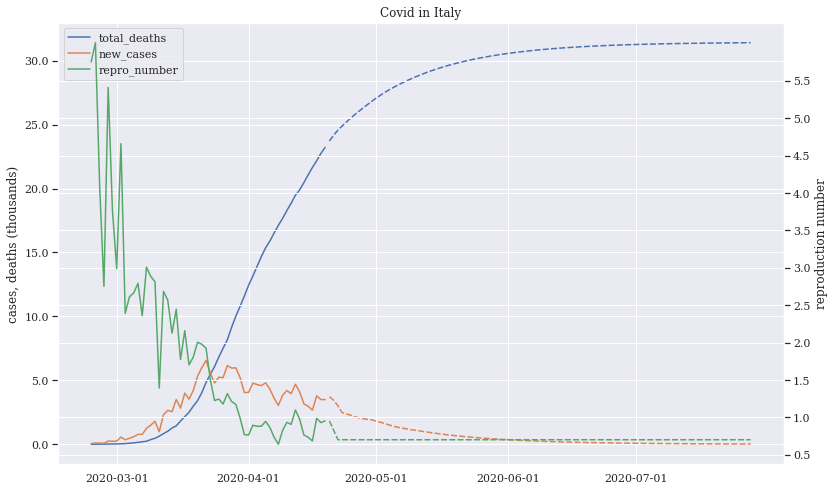

In [68]:
Italy_Cov = forecast(Italy_Cov, 100, repro_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Sweden

In [69]:
Sweden_Cov = df[df['total_cases']>1000].loc['Sweden']
Sweden_Cov[Sweden_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-13,Mon,332,10483,0.001038,0.032183,21.537899,6783.0,0.685243,12,899,0.085758,actual,10099270.0,Europe
2020-04-14,Tue,465,10948,0.001084,0.043402,15.970436,6920.0,0.940751,20,919,0.083942,actual,10099270.0,Europe
2020-04-15,Wed,497,11445,0.001133,0.044396,15.612772,7010.0,0.992582,114,1033,0.090258,actual,10099270.0,Europe
2020-04-16,Thu,482,11927,0.001181,0.041252,16.802841,6980.0,0.966762,170,1203,0.100864,actual,10099270.0,Europe
2020-04-17,Fri,613,12540,0.001242,0.050119,13.830084,7074.0,1.213175,130,1333,0.106300,actual,10099270.0,Europe
2020-04-18,Sat,676,13216,0.001309,0.052505,13.201626,7138.0,1.325862,67,1400,0.105932,actual,10099270.0,Europe
2020-04-19,Sun,606,13822,0.001369,0.044833,15.460540,7379.0,1.149749,111,1511,0.109318,actual,10099270.0,Europe


In [70]:
days_back = 14
target = 0.7
repros= Sweden_Cov[Sweden_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-1.2121514059307408

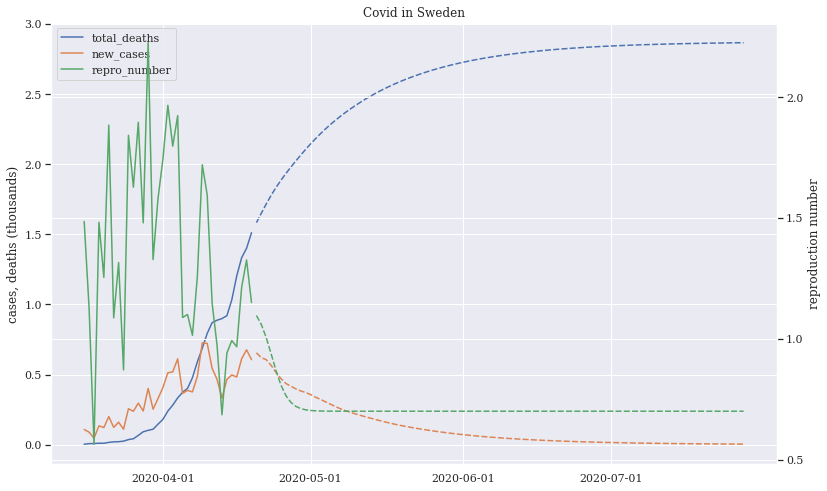

In [71]:
Sweden_Cov = forecast(Sweden_Cov, 100, repro_move=[0.7, 0.05,-4])
plot_cdr(Sweden_Cov, 'Covid in Sweden')

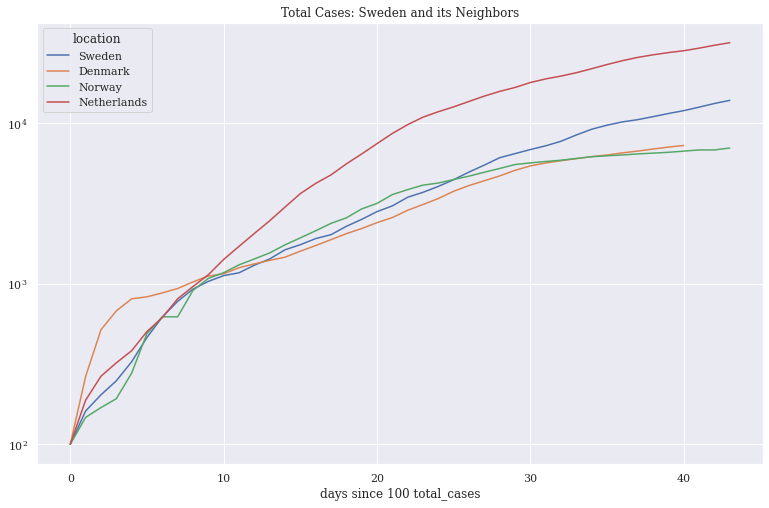

In [72]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Denmark','Norway','Netherlands'], 
            title='Total Cases: Sweden and its Neighbors',logy=True, 
            start=100, column='total_cases')

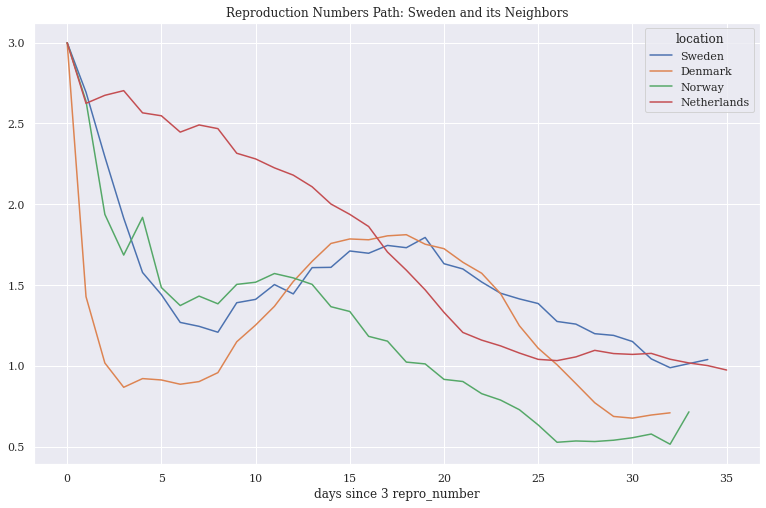

In [73]:
plot_growth(df[df['source']=='actual'],
            locations=['Sweden','Denmark','Norway','Netherlands'], 
            column='repro_number', start=3, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Sweden and its Neighbors')

## The World, Country and Regional Comparisons

In [74]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=14)
World_Cov = order_columns(World_Cov).loc['world']
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-13,Mon,72390,1806607,0.000233,0.040894,16.949649,1091888.0,0.928172,5321,113506,0.062828,actual,7.737500e+09,NaN
2020-04-14,Tue,65962,1872569,0.000242,0.035861,19.328835,1096151.0,0.842464,5339,118845,0.063466,actual,7.737500e+09,NaN
2020-04-15,Wed,75246,1947815,0.000252,0.039397,17.593931,1097043.0,0.960258,7113,125958,0.064666,actual,7.737500e+09,NaN
2020-04-16,Thu,81419,2029234,0.000262,0.040950,16.926609,1101440.0,1.034887,10355,136313,0.067175,actual,7.737500e+09,NaN
2020-04-17,Fri,84339,2113573,0.000273,0.040721,17.021652,1108193.0,1.065470,8507,144820,0.068519,actual,7.737500e+09,NaN
2020-04-18,Sat,83324,2196897,0.000284,0.038666,17.926515,1109757.0,1.051163,8263,153083,0.069681,actual,7.737500e+09,NaN
2020-04-19,Sun,84121,2281018,0.000295,0.037576,18.446577,1107554.0,1.063329,6421,159504,0.069927,actual,7.737500e+09,NaN


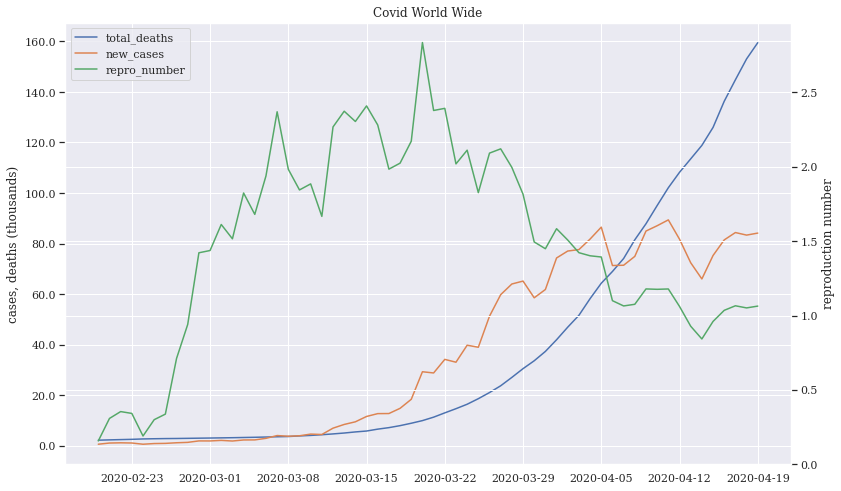

In [75]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide','W')

In [76]:
df[df['source']=='actual'].groupby('location')[['growth','days_to_dbl']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,days_to_dbl
location,,
Sudan,0.723919,0.957493
Ghana,0.263204,2.633498
Angola,0.233615,2.967051
Maldives,0.188052,3.685929
Singapore,0.171037,4.052615
Bangladesh,0.153995,4.501095
Somalia,0.151685,4.569661
Saudi Arabia,0.147125,4.711274
Sierra Leone,0.143101,4.843767


In [77]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
Europe,1015169
North America,789215
Asia,369805
South America,77841
Africa,21057
Oceania,7931


In [78]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','repro_number']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,repro_number
1,United States,735086,1.090006
2,Spain,191726,0.764472
3,Italy,175925,0.952840
4,Germany,139897,0.714194
5,United Kingdom,114217,1.069641


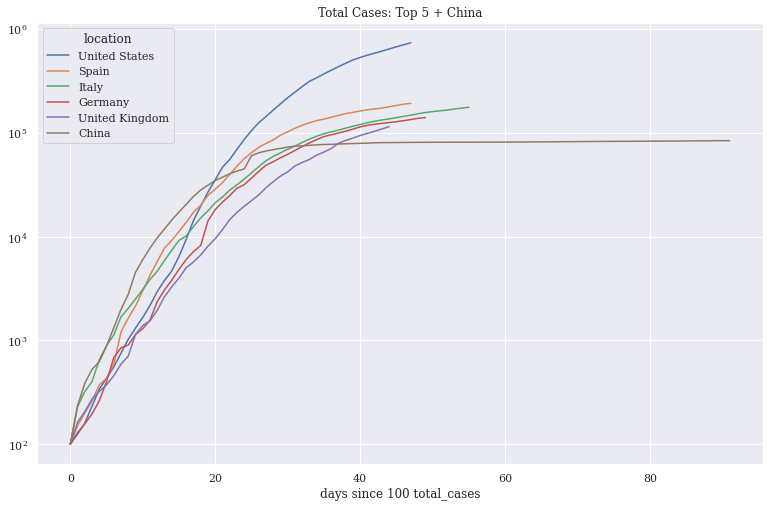

In [79]:
plot_growth(df[df['source']=='actual'], 
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            title='Total Cases: Top 5 + China', 
            start=100, rolling=1, ascending=True, logy=True)

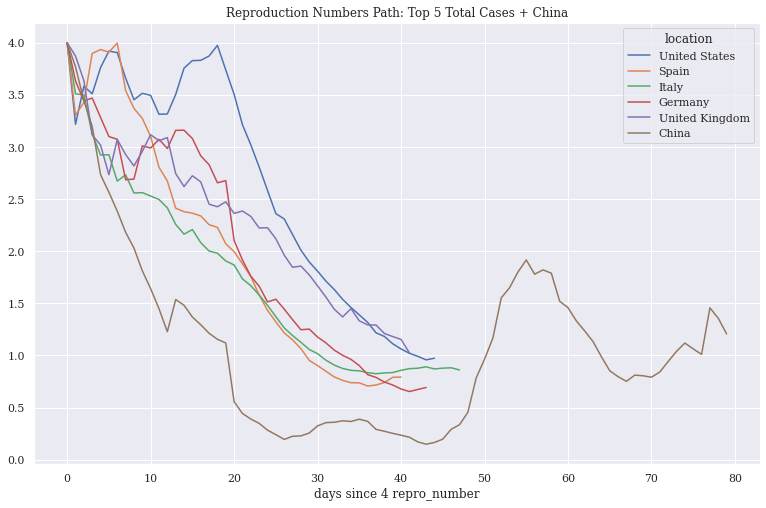

In [80]:
plot_growth(df[df['source']=='actual'],
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            column='repro_number', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Top 5 Total Cases + China')

## U.S. States

### Oklahoma

In [81]:
OK_Cov = df_states[df_states['total_cases']>10].loc['Oklahoma']
OK_Cov[OK_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-12,Sun,102.0,1970,0.000498,0.053165,13.037610,1541.0,0.926671,3.0,96,0.048731,actual,3956971,NA
2020-04-13,Mon,99.0,2069,0.000523,0.049032,14.136670,1588.0,0.872796,2.0,98,0.047366,actual,3956971,NA
2020-04-14,Tue,115.0,2184,0.000552,0.054093,12.814071,1618.0,0.995056,11.0,109,0.049908,actual,3956971,NA
2020-04-15,Wed,79.0,2263,0.000572,0.035533,19.506970,1544.0,0.716321,14.0,123,0.054353,actual,3956971,NA
2020-04-16,Thu,94.0,2357,0.000596,0.040698,17.031373,1478.0,0.890392,8.0,131,0.055579,actual,3956971,NA
2020-04-17,Fri,108.0,2465,0.000623,0.044802,15.471281,1477.0,1.023697,5.0,136,0.055172,actual,3956971,NA
2020-04-18,Sat,105.0,2570,0.000649,0.041714,16.616619,1411.0,1.041814,3.0,139,0.054086,actual,3956971,NA


In [82]:
days_back = 21
target = 0.7
repros= OK_Cov[OK_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-1.8583060024461755

In [83]:
OK_Cov = forecast(OK_Cov, 50, repro_move=(0.7, 0.3))
OK_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-06-01,Mon,10.151474,4241.435085,0.001072,0.002396,289.260373,182.771246,0.700845,0.549049,229.400575,0.054086,forecast,3956971,NA
2020-06-02,Tue,9.647431,4251.082515,0.001074,0.002272,305.084448,173.661925,0.700845,0.521787,229.922362,0.054086,forecast,3956971,NA
2020-06-03,Wed,9.166676,4260.249191,0.001077,0.002154,321.796231,164.984066,0.700845,0.495785,230.418147,0.054086,forecast,3956971,NA
2020-06-04,Thu,8.708664,4268.957855,0.001079,0.002042,339.431717,156.728813,0.700845,0.471013,230.889160,0.054086,forecast,3956971,NA
2020-06-05,Fri,8.272926,4277.230782,0.001081,0.001936,358.021114,148.883160,0.700845,0.447446,231.336606,0.054086,forecast,3956971,NA
2020-06-06,Sat,7.858788,4285.089570,0.001083,0.001836,377.599365,141.432302,0.700845,0.425047,231.761654,0.054086,forecast,3956971,NA
2020-06-07,Sun,7.465474,4292.555043,0.001085,0.001741,398.204373,134.359831,0.700845,0.403775,232.165428,0.054086,forecast,3956971,NA


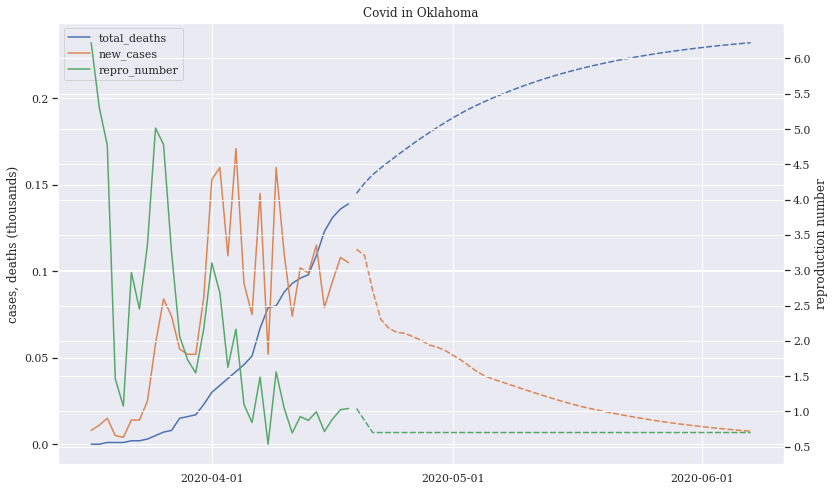

In [84]:
plot_cdr(OK_Cov, 'Covid in Oklahoma')

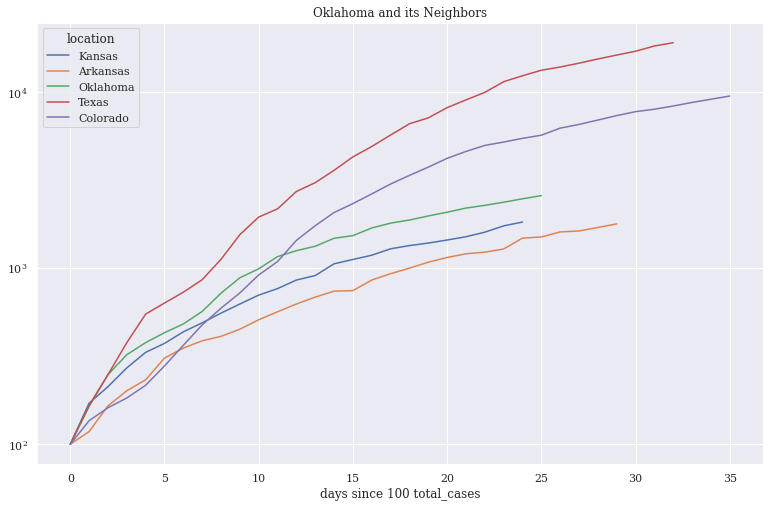

In [85]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Oklahoma and its Neighbors', logy=True, 
            start=100, column='total_cases')

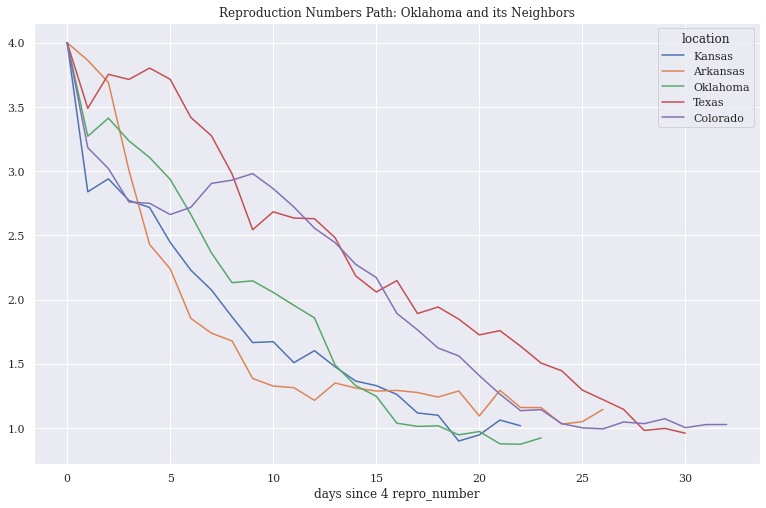

In [86]:
plot_growth(df_states[df_states['source']=='actual'],
            locations=['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'], 
            column='repro_number', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100,
            title='Reproduction Numbers Path: Oklahoma and its Neighbors')

### New York

In [87]:
NY_Cov = df_states[df_states['total_cases']>10].loc['New York']
NY_Cov[NY_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,repro_number,new_deaths,total_deaths,fatality,source,population,region
2020-04-12,Sun,8236.0,188694,0.009700,0.044629,15.531460,129126.0,0.892957,758.0,9385,0.049737,actual,19453561,NA
2020-04-13,Mon,6337.0,195031,0.010025,0.033032,20.984198,127857.0,0.693885,671.0,10056,0.051561,actual,19453561,NA
2020-04-14,Tue,7177.0,202208,0.010394,0.036138,19.180377,126376.0,0.795072,778.0,10834,0.053578,actual,19453561,NA
2020-04-15,Wed,11571.0,213779,0.010989,0.055646,12.456393,129890.0,1.247163,752.0,11586,0.054196,actual,19453561,NA
2020-04-16,Thu,8505.0,222284,0.011426,0.039013,17.767049,129514.0,0.919360,606.0,12192,0.054849,actual,19453561,NA
2020-04-17,Fri,7358.0,229642,0.011805,0.032566,21.284558,126772.0,0.812577,630.0,12822,0.055835,actual,19453561,NA
2020-04-18,Sat,7121.0,236763,0.012171,0.030538,22.697809,121767.0,0.818728,540.0,13362,0.056436,actual,19453561,NA


In [88]:
days_back = 21
target = 0.7
repros= NY_Cov[NY_Cov['source']=='actual'].repro_number-target
repros.pct_change().tail(days_back).mean()

-0.7114517791750244

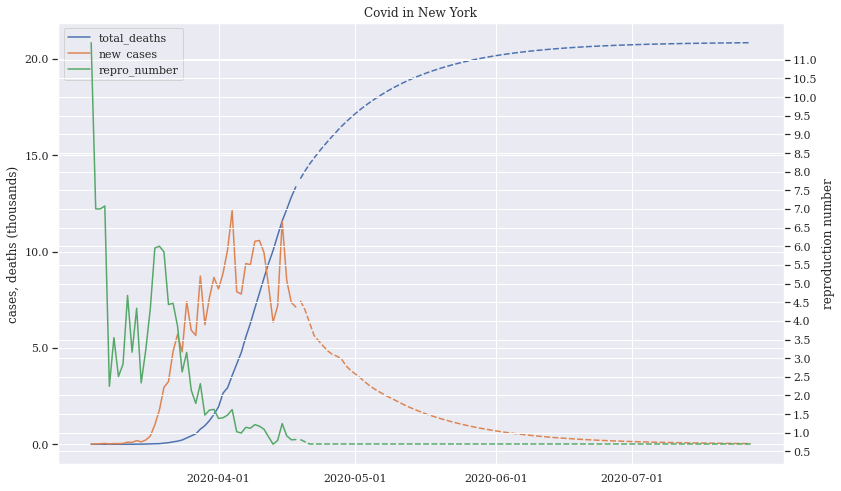

In [89]:
NY_Cov = forecast(NY_Cov, 100, repro_move=(0.7,0.3))
plot_cdr(NY_Cov, 'Covid in New York')

## More on Reproduction Numbers

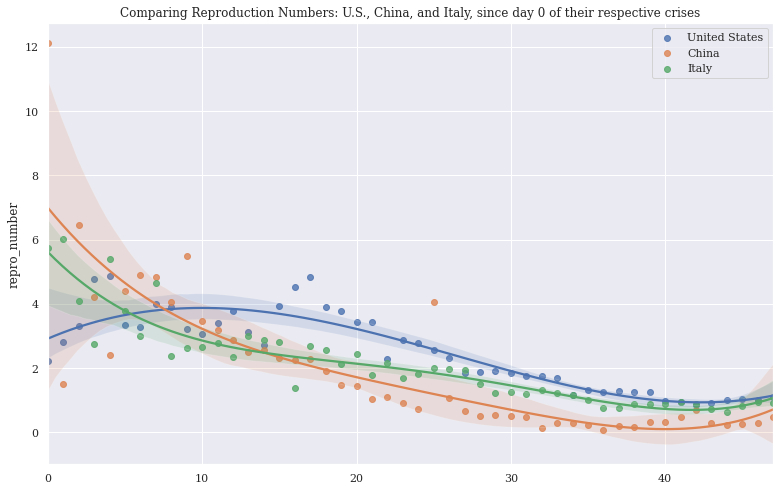

In [90]:
US_ = US_Cov[US_Cov['source']=='actual'].copy()
US_.reset_index(inplace=True)
days = len(US_)

China_ = China_Cov[China_Cov['source']=='actual'][:days].copy()
China_.reset_index(inplace=True)

Italy_ = Italy_Cov[Italy_Cov['source']=='actual'][:days].copy()
Italy_.reset_index(inplace=True)

sns.regplot(x=US_.index, y='repro_number', data=US_, fit_reg=True, order=4, label='United States') 
sns.regplot(x=China_.index, y='repro_number', data=China_, fit_reg=True, order=4, label='China') 
sns.regplot(x=China_.index, y='repro_number', data=Italy_, fit_reg=True, order=4, label='Italy') 

plt.legend()
plt.title('Comparing Reproduction Numbers: U.S., China, and Italy, ' 
          'since day 0 of their respective crises')
plt.show()

#### First stab at an ARIMA model of the U.S. reproduction number. 

Following steps in https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Lots of Warnings!

In [91]:
from statsmodels.tsa.arima_model import ARIMA

actuals = np.log(US_.repro_number)

# fit model
model = ARIMA(actuals, order=(7, 1, 3))
model_fit = model.fit(disp=False)

# make prediction
prediction = model_fit.predict(len(actuals), len(actuals)+100, typ='levels')

# plot results
sns.lineplot(data=np.exp(actuals))
sns.lineplot(data=np.exp(prediction))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


ValueError: ignored

In [0]:
print(model_fit.summary())

In [0]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [0]:
residuals.plot(kind='kde')